Steps:
1. Finalise data sets (be brutal, identify roots and stems; address missing values, model missing value evaluate to mean)
2. Model linear regression statistics (feature importances; chicken feed/auto)
3. Prediction: random forest
4. data visualisation (pairplots)

In [1]:
import pandas as pd

### Covid 19 Cases by County (USA Facts/CDC)

For most states, USAFacts directly collects the daily county-level cumulative totals of positive cases and deaths from a table, dashboard, or PDF on the state public health website. This data is compiled either through scraping or manual entry. The underlying data is available for download below the US county map and has helped government agencies like the Centers for Disease Control and Prevention in its nationwide efforts.

REFERENCES:
1. https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

In [2]:
covid_cases = pd.read_csv("data/covid_confirmed_usafacts_200803.csv")

In [3]:
covid_cases.head()

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,905,921,932,942,965,974,974,1002,1015,1030
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,2461,2513,2662,2708,2770,2835,2835,3028,3101,3142
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,534,539,552,562,569,575,575,585,598,602
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,289,303,318,324,334,337,338,352,363,368


In [4]:
covid_cases_dropped = covid_cases.drop(columns=['8/1/20'])

In [5]:
covid_cases_dropped_only = covid_cases_dropped.iloc[:,-192:]

In [6]:
covid_cases_total = covid_cases_dropped['Total Cases']= covid_cases_dropped.iloc[:, -192:].sum(axis=1)

In [7]:
covid_cases_filter = covid_cases_dropped.loc[:,["countyFIPS", "County Name", "State", "stateFIPS", "Total Cases"]]
covid_cases_filter["countyFIPS"] = covid_cases_filter["countyFIPS"].astype(str)
print(covid_cases_filter.dtypes)

countyFIPS     object
County Name    object
State          object
stateFIPS       int64
Total Cases     int64
dtype: object


In [8]:
covid_cases_filter['countyFIPS_2d'] = covid_cases_filter['countyFIPS'].str[-3:]
covid_cases_filter['countyFIPS'] = covid_cases_filter['countyFIPS'].astype(str).str.zfill(5)
covid_cases_filter['countyFIPS_2d'] = covid_cases_filter['countyFIPS_2d'].astype(str).str.zfill(3)
covid_cases_filter['stateFIPS'] = covid_cases_filter['stateFIPS'].astype(str).str.zfill(2)
covid_cases_filter = covid_cases_filter.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d", "County Name", "State", "Total Cases"]]

In [9]:
covid_cases_clean = covid_cases_filter.copy()

In [10]:
covid_cases_clean = covid_cases_clean.loc[covid_cases_clean['County Name'] != "Statewide Unallocated"]
covid_cases_clean

,countyFIPS,stateFIPS,countyFIPS_2d,County Name,State,Total Cases
1,01001,01,001,Autauga County,AL,39746
2,01003,01,003,Baldwin County,AL,76970
3,01005,01,005,Barbour County,AL,24625
4,01007,01,007,Bibb County,AL,13636
5,01009,01,009,Blount County,AL,19311
...,...,...,...,...,...,...
3190,56037,56,037,Sweetwater County,WY,7361
3191,56039,56,039,Teton County,WY,13823
3192,56041,56,041,Uinta County,WY,9737
3193,56043,56,043,Washakie County,WY,3104


In [11]:
test_cases = covid_cases_clean.loc[(covid_cases_clean["countyFIPS"] == "51560")]
test_cases

,countyFIPS,stateFIPS,countyFIPS_2d,County Name,State,Total Cases


In [12]:
null_data_cases = covid_cases_clean[covid_cases_clean.isnull().any(axis=1)]
null_data_cases

,countyFIPS,stateFIPS,countyFIPS_2d,County Name,State,Total Cases


### Covid 19 Deaths by County (USA Facts/CDC)

For most states, USAFacts directly collects the daily county-level cumulative totals of positive cases and deaths from a table, dashboard, or PDF on the state public health website. This data is compiled either through scraping or manual entry. The underlying data is available for download below the US county map and has helped government agencies like the Centers for Disease Control and Prevention in its nationwide efforts.

REFERENCES:
1. https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/

In [13]:
covid_deaths = pd.read_csv("data/covid_deaths_usafacts_200803.csv")

In [14]:
covid_deaths_dropped = covid_deaths.drop(columns=['8/1/20'])

In [15]:
covid_deaths_total = covid_deaths_dropped['Total Deaths']= covid_deaths_dropped.iloc[:, -192:].sum(axis=1)

In [16]:
covid_deaths_filter = covid_deaths_dropped.loc[:,["countyFIPS", "County Name", "State", "stateFIPS", "Total Deaths"]]

In [17]:
covid_deaths_filter = covid_deaths_dropped.loc[:,["countyFIPS", "County Name", "State", "stateFIPS", "Total Deaths"]]
covid_deaths_filter["countyFIPS"] = covid_deaths_filter["countyFIPS"].astype(str)
print(covid_deaths_filter.dtypes)

countyFIPS      object
County Name     object
State           object
stateFIPS        int64
Total Deaths     int64
dtype: object


In [18]:
covid_deaths_filter['countyFIPS_2d'] = covid_deaths_filter['countyFIPS'].str[-3:]
covid_deaths_filter['countyFIPS'] = covid_deaths_filter['countyFIPS'].astype(str).str.zfill(5)
covid_deaths_filter['countyFIPS_2d'] = covid_deaths_filter['countyFIPS_2d'].astype(str).str.zfill(3)
covid_deaths_filter['stateFIPS'] = covid_deaths_filter['stateFIPS'].astype(str).str.zfill(2)
covid_deaths_filter = covid_deaths_filter.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d", "County Name", "State", "Total Deaths"]]
covid_deaths_filter

,countyFIPS,stateFIPS,countyFIPS_2d,County Name,State,Total Deaths
0,00000,01,000,Statewide Unallocated,AL,0
1,01001,01,001,Autauga County,AL,909
2,01003,01,003,Baldwin County,AL,958
3,01005,01,005,Barbour County,AL,155
4,01007,01,007,Bibb County,AL,103
...,...,...,...,...,...,...
3190,56037,56,037,Sweetwater County,WY,34
3191,56039,56,039,Teton County,WY,101
3192,56041,56,041,Uinta County,WY,0
3193,56043,56,043,Washakie County,WY,291


In [19]:
covid_deaths_clean = covid_deaths_filter.copy()
covid_deaths_clean = covid_deaths_clean.loc[covid_deaths_clean['County Name'] != "Statewide Unallocated"]

In [20]:
covid_deaths_clean.describe()
test_deaths_1 = covid_deaths_clean.loc[(covid_deaths_clean["countyFIPS"] == "15005")]
test_deaths_1

,countyFIPS,stateFIPS,countyFIPS_2d,County Name,State,Total Deaths
561,15005,15,005,Kalawao County,HI,0


In [21]:
null_data_deaths = covid_deaths_clean[covid_deaths_clean.isnull().any(axis=1)]
null_data_deaths

,countyFIPS,stateFIPS,countyFIPS_2d,County Name,State,Total Deaths


In [22]:
covid_deaths_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3146 entries, 1 to 3194
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   countyFIPS     3146 non-null   object
 1   stateFIPS      3146 non-null   object
 2   countyFIPS_2d  3146 non-null   object
 3   County Name    3146 non-null   object
 4   State          3146 non-null   object
 5   Total Deaths   3146 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 172.0+ KB


### Per capital incidence of poverty by U.S county (U.S Census)

The poverty universe is made up of persons for whom the Census Bureau can determine poverty status (either "in poverty" or "not in poverty").

REFERENCES:
1. SAIPE Model Input Data: https://www.census.gov/data/datasets/time-series/demo/saipe/model-tables.html

In [23]:
poverty = pd.read_csv("data/allpovu.csv")
poverty_all_ages = poverty.loc[:,["State FIPS code", "County FIPS code", "Name", "State Postal Code", "Poverty Universe, All Ages"]]
poverty_all_ages.rename(columns={'State FIPS code': 'stateFIPS', 'County FIPS code': 'countyFIPS_2d'}, inplace=True)
poverty_all_ages

,stateFIPS,countyFIPS_2d,Name,State Postal Code,"Poverty Universe, All Ages"
0,0,0,United States,US,319184033.0
1,1,0,Alabama,AL,4763811.0
2,1,1,Autauga County,AL,55073.0
3,1,3,Baldwin County,AL,215255.0
4,1,5,Barbour County,AL,21979.0
...,...,...,...,...,...
3196,56,37,Sweetwater County,WY,42205.0
3197,56,39,Teton County,WY,22888.0
3198,56,41,Uinta County,WY,20135.0
3199,56,43,Washakie County,WY,7735.0


In [24]:
poverty_all_ages.rename(columns={'Name': 'County Name', 'State Postal Code': 'State'}, inplace=True)
poverty_clean = poverty_all_ages.copy()
poverty_clean['countyFIPS_2d'] = poverty_clean['countyFIPS_2d'].astype(str).str.zfill(3)
poverty_clean['stateFIPS'] = poverty_clean['stateFIPS'].astype(str).str.zfill(2)
poverty_clean["countyFIPS"] = poverty_clean["stateFIPS"] + poverty_clean["countyFIPS_2d"]

In [25]:
poverty_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stateFIPS                   3201 non-null   object 
 1   countyFIPS_2d               3201 non-null   object 
 2   County Name                 3201 non-null   object 
 3   State                       3201 non-null   object 
 4   Poverty Universe, All Ages  3193 non-null   float64
 5   countyFIPS                  3201 non-null   object 
dtypes: float64(1), object(5)
memory usage: 150.2+ KB


In [26]:
poverty_clean = poverty_clean.loc[poverty_clean['countyFIPS_2d'] != 0]

In [27]:
poverty_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stateFIPS                   3201 non-null   object 
 1   countyFIPS_2d               3201 non-null   object 
 2   County Name                 3201 non-null   object 
 3   State                       3201 non-null   object 
 4   Poverty Universe, All Ages  3193 non-null   float64
 5   countyFIPS                  3201 non-null   object 
dtypes: float64(1), object(5)
memory usage: 175.1+ KB


In [28]:
null_data_pov = poverty_clean[poverty_clean.isnull().any(axis=1)]
null_data_pov

,stateFIPS,countyFIPS_2d,County Name,State,"Poverty Universe, All Ages",countyFIPS
92,02,201,Prince of Wales-Outer Ketchikan Census Area,AK,NaN,02201
95,02,232,Skagway-Hoonah-Angoon Census Area,AK,NaN,02232
98,02,270,Wade Hampton Census Area,AK,NaN,02270
100,02,280,Wrangell-Petersburg Census Area,AK,NaN,02280
565,15,005,Kalawao County,HI,NaN,15005
2465,46,113,Shannon County,SD,NaN,46113
2969,51,515,Bedford city,VA,NaN,51515
2974,51,560,Clifton Forge,VA,NaN,51560


In [29]:
poverty_clean['Poverty Universe, All Ages'] = poverty_clean['Poverty Universe, All Ages'].fillna((poverty_clean['Poverty Universe, All Ages'].mean()))

In [30]:
poverty_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stateFIPS                   3201 non-null   object 
 1   countyFIPS_2d               3201 non-null   object 
 2   County Name                 3201 non-null   object 
 3   State                       3201 non-null   object 
 4   Poverty Universe, All Ages  3201 non-null   float64
 5   countyFIPS                  3201 non-null   object 
dtypes: float64(1), object(5)
memory usage: 175.1+ KB


In [31]:
test_pov = poverty_clean.loc[(poverty_clean["countyFIPS"] == "46102")]
test_pov

,stateFIPS,countyFIPS_2d,County Name,State,"Poverty Universe, All Ages",countyFIPS
2459,46,102,Oglala Lakota County,SD,14235.0,46102


### County Population by Racial/Ethnic Characteristics 2010-2019 (U.S. Census Bureau)

METHODOLOGY FOR THE UNITED STATES POPULATION ESTIMATES: VINTAGE 2019
Nation, States, Counties, and Puerto Rico – April 1, 2010 to July 1, 2019

Each year, the United States Census Bureau produces and publishes estimates of the population for the
nation, states, counties, state/county equivalents, and Puerto Rico.1 We estimate the resident population for
each year since the most recent decennial census by using measures of population change. The resident
population includes all people currently residing in the United States.

With each annual release of population estimates, the Population Estimates Program revises and updates the
entire time series of estimates from April 1, 2010 to July 1 of the current year, which we refer to as the
vintage year. We use the term “vintage” to denote an entire time series created with a consistent population
starting point and methodology. The release of a new vintage of estimates supersedes any previous series
and incorporates the most up-to-date input data and methodological improvements

REFERENCES:
1. Annual County Resident Population Estimates by Age, Sex, Race, and Hispanic Origin: April 1, 2010 to July 1, 2019 (https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html)
2. File Layout: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf

In [32]:
race = pd.read_csv("data/cc-est2019-alldata.csv", encoding = "ISO-8859-1")

In [33]:
# race.columns.tolist()

# SELECTION - Z Value
# sum columns by race and gender 
# e.g. race["WA_MALE_TOTAL"] = race.loc[:, ["WA_MALE", "WAC_MALE"].sum()

# WA_MALE
# WAC_MALE

# WA_FEMALE
# WAC_FEMALE

# BA_MALE
# BAC_MALE

# BA_FEMALE
# BAC_FEMALE

# IA_MALE
# IAC_MALE

# IA_FEMALE
# IAC_FEMALE

# AA_MALE
# AAC_MALE 

# AA_FEMALE
# AAC_FEMALE

# NA_MALE
# NAC_MALE 

# NA_FEMALE
# NAC_FEMALE

# TOM_MALE
# TOM_FEMALE

race["WA_MALE_TOTAL"] = race.loc[:, ["WA_MALE", "WAC_MALE"]].sum(axis=1)
race["WA_FEMALE_TOTAL"] = race.loc[:, ["WA_FEMALE", "WAC_FEMALE"]].sum(axis=1)
race["BA_MALE_TOTAL"] = race.loc[:, ["BA_MALE", "BAC_MALE"]].sum(axis=1)
race["BA_FEMALE_TOTAL"] = race.loc[:, ["BA_FEMALE", "BAC_FEMALE"]].sum(axis=1)
race["IA_MALE_TOTAL"] = race.loc[:, ["IA_MALE", "IAC_MALE"]].sum(axis=1)
race["IA_FEMALE_TOTAL"] = race.loc[:, ["IA_FEMALE", "IAC_FEMALE"]].sum(axis=1)
race["AA_MALE_TOTAL"] = race.loc[:, ["AA_MALE", "AAC_MALE"]].sum(axis=1)
race["AA_FEMALE_TOTAL"] = race.loc[:, ["AA_FEMALE", "AAC_FEMALE"]].sum(axis=1)
race["NA_MALE_TOTAL"] = race.loc[:, ["NA_MALE", "NAC_MALE"]].sum(axis=1)
race["NA_FEMALE_TOTAL"] = race.loc[:, ["NA_FEMALE", "NAC_FEMALE"]].sum(axis=1)

In [34]:
race["YEAR"] = race["YEAR"].astype(int)
race

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL
0,50,1,1,Alabama,Autauga County,1,0,54571,26569,28002,...,42928,44393,9263,10436,396,453,500,693,71,55
1,50,1,1,Alabama,Autauga County,1,1,3579,1866,1713,...,2890,2684,767,679,28,21,47,43,4,1
2,50,1,1,Alabama,Autauga County,1,2,3991,2001,1990,...,3091,3109,824,777,41,27,49,63,4,7
3,50,1,1,Alabama,Autauga County,1,3,4290,2171,2119,...,3352,3301,884,842,44,39,55,55,8,6
4,50,1,1,Alabama,Autauga County,1,4,4290,2213,2077,...,3292,3209,1027,868,35,27,64,45,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716371,50,56,45,Wyoming,Weston County,12,14,499,280,219,...,514,409,1,2,7,2,38,25,0,0
716372,50,56,45,Wyoming,Weston County,12,15,352,180,172,...,349,339,0,1,4,2,7,2,0,0
716373,50,56,45,Wyoming,Weston County,12,16,229,107,122,...,212,240,0,0,2,4,0,0,0,0
716374,50,56,45,Wyoming,Weston County,12,17,198,82,116,...,161,230,0,0,2,2,1,0,0,0


In [35]:
# Current is constrained to YEAR: 12 = 7/1/2019 & AGEGRP: 0 = Total

race_current = race.loc[(race['YEAR'] == 12) & (race['AGEGRP'] == 0)]
race_current.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 209 to 716357
Data columns (total 90 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   SUMLEV           3142 non-null   int64 
 1   STATE            3142 non-null   int64 
 2   COUNTY           3142 non-null   int64 
 3   STNAME           3142 non-null   object
 4   CTYNAME          3142 non-null   object
 5   YEAR             3142 non-null   int64 
 6   AGEGRP           3142 non-null   int64 
 7   TOT_POP          3142 non-null   int64 
 8   TOT_MALE         3142 non-null   int64 
 9   TOT_FEMALE       3142 non-null   int64 
 10  WA_MALE          3142 non-null   int64 
 11  WA_FEMALE        3142 non-null   int64 
 12  BA_MALE          3142 non-null   int64 
 13  BA_FEMALE        3142 non-null   int64 
 14  IA_MALE          3142 non-null   int64 
 15  IA_FEMALE        3142 non-null   int64 
 16  AA_MALE          3142 non-null   int64 
 17  AA_FEMALE        3142 non-nul

In [36]:
race_current.loc[:,["STATE", "COUNTY", "STNAME", "CTYNAME", "TOT_POP", "WA_MALE_TOTAL", "WA_FEMALE_TOTAL"
               , "BA_MALE_TOTAL", "BA_FEMALE_TOTAL", "IA_MALE_TOTAL", "IA_FEMALE_TOTAL"
               , "AA_MALE_TOTAL", "AA_FEMALE_TOTAL", "NA_MALE_TOTAL", "NA_FEMALE_TOTAL"]]

,STATE,COUNTY,STNAME,CTYNAME,TOT_POP,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL
209,1,1,Alabama,Autauga County,55869,42250,43920,10751,12270,395,446,727,879,87,75
437,1,3,Alabama,Baldwin County,223234,191540,202761,19832,21115,2721,2624,2337,3394,254,267
665,1,5,Alabama,Barbour County,24686,12906,11608,12743,11280,285,182,127,141,72,41
893,1,7,Alabama,Bibb County,22394,17635,16976,5951,3719,159,151,72,73,50,16
1121,1,9,Alabama,Blount County,57826,54866,56713,1174,1080,592,598,232,265,102,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715445,56,37,Wyoming,Sweetwater County,42343,41325,38927,828,640,881,801,516,619,97,99
715673,56,39,Wyoming,Teton County,23464,23328,21591,248,181,310,272,358,573,63,43
715901,56,41,Wyoming,Uinta County,20226,19698,19209,199,186,391,402,123,180,54,44
716129,56,43,Wyoming,Washakie County,7805,7602,7321,80,57,169,198,66,102,13,13


In [37]:
race_current.describe()

,SUMLEV,STATE,COUNTY,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,...,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL
count,3142.0,3142.000000,3142.000000,3142.0,3142.0,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,...,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3.142000e+03,3.142000e+03,3142.000000,3142.000000
mean,50.0,30.280076,103.572884,12.0,0.0,1.044683e+05,5.145045e+04,5.301789e+04,3.952652e+04,4.020683e+04,...,8.033665e+04,8.171576e+04,1.408558e+04,1.528941e+04,1771.046467,1772.443030,6.459161e+03,7.024877e+03,387.793125,382.213558
std,0.0,15.144339,107.704060,0.0,0.0,3.334567e+05,1.638677e+05,1.696276e+05,1.179341e+05,1.190460e+05,...,2.401430e+05,2.424334e+05,5.646954e+04,6.512335e+04,6577.875055,6677.061211,4.455279e+04,4.892902e+04,3681.779723,3625.889024
min,50.0,1.000000,1.000000,12.0,0.0,8.600000e+01,4.100000e+01,4.500000e+01,1.300000e+01,1.100000e+01,...,2.900000e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,50.0,18.000000,35.000000,12.0,0.0,1.090250e+04,5.459750e+03,5.407250e+03,4.544250e+03,4.461750e+03,...,9.183000e+03,8.992500e+03,2.190000e+02,1.482500e+02,121.000000,115.000000,6.500000e+01,7.700000e+01,9.000000,8.000000
50%,50.0,29.000000,79.000000,12.0,0.0,2.572600e+04,1.286900e+04,1.282850e+04,1.094450e+04,1.101950e+04,...,2.210150e+04,2.229450e+04,1.278500e+03,8.390000e+02,325.000000,300.000000,2.040000e+02,2.320000e+02,28.000000,25.000000
75%,50.0,45.000000,133.000000,12.0,0.0,6.807275e+04,3.415225e+04,3.451250e+04,2.910775e+04,2.975875e+04,...,5.877825e+04,6.018950e+04,6.424000e+03,6.014000e+03,1008.750000,971.750000,9.527500e+02,1.083000e+03,108.750000,100.000000
max,50.0,56.000000,840.000000,12.0,0.0,1.003911e+07,4.949041e+06,5.090066e+06,3.552806e+06,3.545503e+06,...,7.240650e+06,7.229593e+06,1.140998e+06,1.362219e+06,188264.000000,185298.000000,1.529785e+06,1.731856e+06,171165.000000,166656.000000


In [38]:
race_current.rename(columns={'CTYNAME': 'County Name'}, inplace=True)
race_current.rename(columns={'STATE': 'stateFIPS'}, inplace=True)
race_current.rename(columns={'COUNTY': 'countyFIPS_2d'}, inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [39]:
race_current['countyFIPS_2d'] = race_current['countyFIPS_2d'].astype(str).str.zfill(3)
race_current['stateFIPS'] = race_current['stateFIPS'].astype(str).str.zfill(2)
race_current["countyFIPS"] = race_current["stateFIPS"] + race_current["countyFIPS_2d"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [40]:
test_race_sd = race_current.loc[(race_current["countyFIPS"] == "46102")]
test_race_sd

,SUMLEV,stateFIPS,countyFIPS_2d,STNAME,County Name,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL,countyFIPS
550145,50,46,102,South Dakota,Oglala Lakota County,12,0,14177,6961,7216,...,844,94,69,12904,13475,29,37,12,13,46102


In [41]:
race_clean = race_current.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d", "STNAME", "County Name", "TOT_POP", "WA_MALE_TOTAL", "WA_FEMALE_TOTAL"
               , "BA_MALE_TOTAL", "BA_FEMALE_TOTAL", "IA_MALE_TOTAL", "IA_FEMALE_TOTAL"
               , "AA_MALE_TOTAL", "AA_FEMALE_TOTAL", "NA_MALE_TOTAL", "NA_FEMALE_TOTAL"]]

In [42]:
null_data_race = race_clean[race_clean.isnull().any(axis=1)]
null_data_race

,countyFIPS,stateFIPS,countyFIPS_2d,STNAME,County Name,TOT_POP,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL


In [43]:
test_race = race_clean.loc[(race_clean["countyFIPS"] == "46102")]
test_race

,countyFIPS,stateFIPS,countyFIPS_2d,STNAME,County Name,TOT_POP,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL
550145,46102,46,102,South Dakota,Oglala Lakota County,14177,889,844,94,69,12904,13475,29,37,12,13


In [44]:
race_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 209 to 716357
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   countyFIPS       3142 non-null   object
 1   stateFIPS        3142 non-null   object
 2   countyFIPS_2d    3142 non-null   object
 3   STNAME           3142 non-null   object
 4   County Name      3142 non-null   object
 5   TOT_POP          3142 non-null   int64 
 6   WA_MALE_TOTAL    3142 non-null   int64 
 7   WA_FEMALE_TOTAL  3142 non-null   int64 
 8   BA_MALE_TOTAL    3142 non-null   int64 
 9   BA_FEMALE_TOTAL  3142 non-null   int64 
 10  IA_MALE_TOTAL    3142 non-null   int64 
 11  IA_FEMALE_TOTAL  3142 non-null   int64 
 12  AA_MALE_TOTAL    3142 non-null   int64 
 13  AA_FEMALE_TOTAL  3142 non-null   int64 
 14  NA_MALE_TOTAL    3142 non-null   int64 
 15  NA_FEMALE_TOTAL  3142 non-null   int64 
dtypes: int64(11), object(5)
memory usage: 417.3+ KB


### Incidence of Pre-existing Conditions & Coverage of Flu Vaccine

People of any age with the following conditions are at increased risk of severe illness from COVID-19 (according to CDC, 17 July 17 2020:

PolicyMap worked with journalists at the New York Times to create this index assessing a county’s relative risk of its population developing severe COVID-19 symptoms. The index represents the relative risk for a high proportion of residents in each county to develop serious health complications from COVID-19 because of underlying health conditions identified by the CDC as contributing to a person’s risk of developing severe symptoms from the virus. These conditions include COPD, heart disease, high blood pressure, diabetes, and obesity.

Estimates of COPD, heart disease, high blood pressure, and diabetes and obesity prevalence at the tract and ZCTA level are from PolicyMap’s Health Outcome Estimates. Estimates of diabetes and obesity prevalence at the county level are from the CDC’s U.S. Diabetes Surveillance System.

Normalized scores were then converted to percentiles and z scores for easier interpretation. Percentiles rank counties from the lowest score to the highest on a scale of 0 to 100, where a score of 50 represents the median value. A county’s z score shows how many standard deviations above or below the average a county’s risk level falls. A score of 0.6, for example, would mean that the county has a higher risk than average, but is still within one standard deviation of the average and is therefore not unusually high. Risk categories from very low to very high are assigned based on z scores.

Constrained features to the following (according to CDC advisory 28 July, 2020):
- Serious heart conditions, such as heart failure, coronary artery disease, or cardiomyopathies (CVDINFR4, CVDCRHD4)
- Cancer (CHCOCNCR)
- Chronic kidney disease (CHCKDNY)
- COPD (CHCCOPD1)
- Obesity (BMI> 30) ( _BMI5CAT value 4; not available at county level)
- Sickle cell disease (not available)
- Solid organ transplantation 
- Type 2 diabetes mellitus (proxy; taking insulin: INSULIN)


Proxy Prevention Coverage
- Adult flu shot/spray past 12 mos (FLUSHOT6)


REFERENCES:
1. Covid 19 People with Certain Medical Conditions https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/people-with-medical-conditions.html?CDC_AA_refVal=https%3A%2F%2Fwww.cdc.gov%2Fcoronavirus%2F2019-ncov%2Fneed-extra-precautions%2Fgroups-at-higher-risk.html
2. Centers for Disease Control and Prevention (CDC). Behavioral Risk Factor Surveillance System Survey Data. Atlanta, Georgia: U.S. Department of Health and Human Services, Centers for Disease Control and Prevention, 2017.: https://www.cdc.gov/brfss/smart/smart_2017.html
3. Evidence used to update the list of underlying medical conditions that increase a person’s risk of severe illness from COVID-19: https://www.cdc.gov/coronavirus/2019-ncov/need-extra-precautions/evidence-table.html
4. PolicyMap Severe COVID-19 Health Risk Index: https://www.policymap.com/download-covid19-data/

In [45]:
# CDC SMART Data
# preexisting = pd.read_sas("data/llcp2018_2.xpt")
# preexisting.to_csv('data/llcp2018.csv')
# preexisting = pd.read_csv("data/MMSA2017.csv")
# preexisting["_MMSA"] = preexisting["_MMSA"].astype(str)
# print(preexisting.dtypes)
# preexisting['countyFIPS_2d'] = preexisting['_MMSA'].str[2:4]
# preexisting['stateFIPS_2d'] = preexisting['_MMSA'].str[0:2]

In [46]:
preexisting = pd.read_csv("data/risk_clean6.csv")

In [47]:
preexisting

,countyFIPS,stateFIPS,countyFIPS_2d,index_percentile,index_category
0,1001,1,1,65.42,Above Average
1,1003,1,3,68.39,Above Average
2,1005,1,5,97.09,High
3,1007,1,7,83.36,Above Average
4,1009,1,9,81.75,Above Average
...,...,...,...,...,...
3138,56037,56,37,10.42,Low
3139,56039,56,39,2.94,Very low
3140,56041,56,41,27.13,Below Average
3141,56043,56,43,32.76,Below Average


In [48]:
print(preexisting.dtypes)

countyFIPS            int64
stateFIPS             int64
countyFIPS_2d         int64
index_percentile    float64
index_category       object
dtype: object


In [49]:
preexisting.describe()

,countyFIPS,stateFIPS,countyFIPS_2d,index_percentile
count,3143.000000,3143.000000,3143.000000,3143.000000
mean,30390.372574,30.286669,103.703786,48.120646
std,15164.780323,15.146439,107.936692,181.451891
min,1001.000000,1.000000,1.000000,-9999.000000
25%,18178.000000,18.000000,35.000000,27.020000
50%,29177.000000,29.000000,79.000000,51.380000
75%,45082.000000,45.000000,133.000000,75.470000
max,56045.000000,56.000000,840.000000,100.000000


In [50]:
preexisting.rename(columns={'index_percentile': 'Risk Index'}, inplace=True)

In [51]:
preexisting["countyFIPS"] = preexisting["countyFIPS"].astype(str).str.zfill(5)
preexisting["stateFIPS"] = preexisting["stateFIPS"].astype(str).str.zfill(2)
preexisting["countyFIPS_2d"] = preexisting["countyFIPS_2d"].astype(str).str.zfill(3)

# preexisting["Risk Index"] = preexisting["Risk Index"].astype(str)

In [52]:
null_data_preexisting = preexisting[preexisting.isnull().any(axis=1)]
null_data_preexisting

,countyFIPS,stateFIPS,countyFIPS_2d,Risk Index,index_category
2916,51515,51,515,-9999.0,NaN


In [53]:
preexisting_clean = preexisting.dropna()

In [54]:
null_data_preexisting = preexisting_clean[preexisting_clean.isnull().any(axis=1)]
null_data_preexisting

,countyFIPS,stateFIPS,countyFIPS_2d,Risk Index,index_category


In [55]:
test_preexisting = preexisting_clean.loc[(preexisting_clean["countyFIPS"] == "1001")]
test_preexisting

,countyFIPS,stateFIPS,countyFIPS_2d,Risk Index,index_category


In [56]:
test_preexisting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   countyFIPS      0 non-null      object 
 1   stateFIPS       0 non-null      object 
 2   countyFIPS_2d   0 non-null      object 
 3   Risk Index      0 non-null      float64
 4   index_category  0 non-null      object 
dtypes: float64(1), object(4)
memory usage: 0.0+ bytes


### Flu Coverage (CDC Wonder)? 

## Merging DataFrames

In [57]:
merge_cases_death = covid_cases_clean.merge(covid_deaths_clean, on=["stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

In [58]:
merge_cases_death.info()
null_data_m_1 = merge_cases_death[merge_cases_death.isnull().any(axis=1)]
null_data_m_1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3145 entries, 0 to 3144
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   countyFIPS     3145 non-null   object
 1   stateFIPS      3145 non-null   object
 2   countyFIPS_2d  3145 non-null   object
 3   County Name_x  3145 non-null   object
 4   State_x        3145 non-null   object
 5   Total Cases    3145 non-null   int64 
 6   County Name_y  3145 non-null   object
 7   State_y        3145 non-null   object
 8   Total Deaths   3145 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 245.7+ KB


,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths


In [59]:
merge_cases_death

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths
0,01001,01,001,Autauga County,AL,39746,Autauga County,AL,909
1,01003,01,003,Baldwin County,AL,76970,Baldwin County,AL,958
2,01005,01,005,Barbour County,AL,24625,Barbour County,AL,155
3,01007,01,007,Bibb County,AL,13636,Bibb County,AL,103
4,01009,01,009,Blount County,AL,19311,Blount County,AL,82
...,...,...,...,...,...,...,...,...,...
3140,56037,56,037,Sweetwater County,WY,7361,Sweetwater County,WY,34
3141,56039,56,039,Teton County,WY,13823,Teton County,WY,101
3142,56041,56,041,Uinta County,WY,9737,Uinta County,WY,0
3143,56043,56,043,Washakie County,WY,3104,Washakie County,WY,291


In [60]:
merge_cases_death_pov = merge_cases_death.merge(poverty_clean, on=["stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

In [61]:
merge_cases_death_pov

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name,State,"Poverty Universe, All Ages"
0,01001,01,001,Autauga County,AL,39746,Autauga County,AL,909,Autauga County,AL,55073.0
1,01003,01,003,Baldwin County,AL,76970,Baldwin County,AL,958,Baldwin County,AL,215255.0
2,01005,01,005,Barbour County,AL,24625,Barbour County,AL,155,Barbour County,AL,21979.0
3,01007,01,007,Bibb County,AL,13636,Bibb County,AL,103,Bibb County,AL,20212.0
4,01009,01,009,Blount County,AL,19311,Blount County,AL,82,Blount County,AL,57238.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3140,56037,56,037,Sweetwater County,WY,7361,Sweetwater County,WY,34,Sweetwater County,WY,42205.0
3141,56039,56,039,Teton County,WY,13823,Teton County,WY,101,Teton County,WY,22888.0
3142,56041,56,041,Uinta County,WY,9737,Uinta County,WY,0,Uinta County,WY,20135.0
3143,56043,56,043,Washakie County,WY,3104,Washakie County,WY,291,Washakie County,WY,7735.0


In [62]:
test_data_m_2 = merge_cases_death_pov.loc[(merge_cases_death_pov["countyFIPS"] == "02270")]
test_data_m_2

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name,State,"Poverty Universe, All Ages"
93,02270,02,270,Wade Hampton Census Area,AK,0,Wade Hampton Census Area,AK,0,Wade Hampton Census Area,AK,299891.036329


In [63]:
merge_cases_death_pov.info()

null_data_m_2 = merge_cases_death_pov[merge_cases_death_pov.isnull().any(axis=1)]
null_data_m_2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3145 entries, 0 to 3144
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3145 non-null   object 
 1   stateFIPS                   3145 non-null   object 
 2   countyFIPS_2d               3145 non-null   object 
 3   County Name_x               3145 non-null   object 
 4   State_x                     3145 non-null   object 
 5   Total Cases                 3145 non-null   int64  
 6   County Name_y               3145 non-null   object 
 7   State_y                     3145 non-null   object 
 8   Total Deaths                3145 non-null   int64  
 9   County Name                 3144 non-null   object 
 10  State                       3144 non-null   object 
 11  Poverty Universe, All Ages  3144 non-null   float64
dtypes: float64(1), int64(2), object(9)
memory usage: 319.4+ KB


,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name,State,"Poverty Universe, All Ages"
1830,00001,36,001,New York City Unallocated/Probable,NY,739,New York City Unallocated/Probable,NY,79004,NaN,NaN,NaN


In [64]:
merge_cases_death_pov_2 = merge_cases_death_pov.dropna()

In [65]:
null_data_m_3 = merge_cases_death_pov_2[merge_cases_death_pov_2.isnull().any(axis=1)]
null_data_m_3

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name,State,"Poverty Universe, All Ages"


In [66]:
merge_cases_death_pov_race = merge_cases_death_pov_2.merge(race_clean, on=[
    "stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

In [67]:
merge_cases_death_pov_race["countyFIPS"] = merge_cases_death_pov_race["countyFIPS"].astype(str).str.zfill(5)
merge_cases_death_pov_race.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144 entries, 0 to 3143
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3144 non-null   object 
 1   stateFIPS                   3144 non-null   object 
 2   countyFIPS_2d               3144 non-null   object 
 3   County Name_x               3144 non-null   object 
 4   State_x                     3144 non-null   object 
 5   Total Cases                 3144 non-null   int64  
 6   County Name_y               3144 non-null   object 
 7   State_y                     3144 non-null   object 
 8   Total Deaths                3144 non-null   int64  
 9   County Name_x               3144 non-null   object 
 10  State                       3144 non-null   object 
 11  Poverty Universe, All Ages  3144 non-null   float64
 12  STNAME                      3142 non-null   object 
 13  County Name_y               3142 

In [68]:
merge_cases_death_pov_race.info()

null_data_m_4 = merge_cases_death_pov_race[merge_cases_death_pov_race.isnull().any(axis=1)]
null_data_m_4

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144 entries, 0 to 3143
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3144 non-null   object 
 1   stateFIPS                   3144 non-null   object 
 2   countyFIPS_2d               3144 non-null   object 
 3   County Name_x               3144 non-null   object 
 4   State_x                     3144 non-null   object 
 5   Total Cases                 3144 non-null   int64  
 6   County Name_y               3144 non-null   object 
 7   State_y                     3144 non-null   object 
 8   Total Deaths                3144 non-null   int64  
 9   County Name_x               3144 non-null   object 
 10  State                       3144 non-null   object 
 11  Poverty Universe, All Ages  3144 non-null   float64
 12  STNAME                      3142 non-null   object 
 13  County Name_y               3142 

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name_x,...,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL
93,02270,02,270,Wade Hampton Census Area,AK,0,Wade Hampton Census Area,AK,0,Wade Hampton Census Area,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,06000,06,000,Grand Princess Cruise Ship,CA,3087,Grand Princess Cruise Ship,CA,0,California,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
merge_cases_death_pov_race_2 = merge_cases_death_pov_race.dropna()


test_data_m_5 = merge_cases_death_pov_race_2.loc[(merge_cases_death_pov_race_2["countyFIPS"] == "06000")]
test_data_m_5

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name_x,...,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL


In [71]:
# merge_cases_death_pov_race_2["countyFIPS"] = merge_cases_death_pov_race_2["countyFIPS"].astype(str).str.zfill(5)
merge_cases_death_pov_race_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3143
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3142 non-null   object 
 1   stateFIPS                   3142 non-null   object 
 2   countyFIPS_2d               3142 non-null   object 
 3   County Name_x               3142 non-null   object 
 4   State_x                     3142 non-null   object 
 5   Total Cases                 3142 non-null   int64  
 6   County Name_y               3142 non-null   object 
 7   State_y                     3142 non-null   object 
 8   Total Deaths                3142 non-null   int64  
 9   County Name_x               3142 non-null   object 
 10  State                       3142 non-null   object 
 11  Poverty Universe, All Ages  3142 non-null   float64
 12  STNAME                      3142 non-null   object 
 13  County Name_y               3142 

In [72]:
merge_cases_death_pov_race_2 = merge_cases_death_pov_race_2.merge(preexisting_clean, on=["stateFIPS", "countyFIPS_2d", "countyFIPS"], how='left', validate="1:1")

In [73]:
merge_cases_death_pov_race_2

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name_x,...,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL,Risk Index,index_category
0,01001,01,001,Autauga County,AL,39746,Autauga County,AL,909,Autauga County,...,10751.0,12270.0,395.0,446.0,727.0,879.0,87.0,75.0,65.42,Above Average
1,01003,01,003,Baldwin County,AL,76970,Baldwin County,AL,958,Baldwin County,...,19832.0,21115.0,2721.0,2624.0,2337.0,3394.0,254.0,267.0,68.39,Above Average
2,01005,01,005,Barbour County,AL,24625,Barbour County,AL,155,Barbour County,...,12743.0,11280.0,285.0,182.0,127.0,141.0,72.0,41.0,97.09,High
3,01007,01,007,Bibb County,AL,13636,Bibb County,AL,103,Bibb County,...,5951.0,3719.0,159.0,151.0,72.0,73.0,50.0,16.0,83.36,Above Average
4,01009,01,009,Blount County,AL,19311,Blount County,AL,82,Blount County,...,1174.0,1080.0,592.0,598.0,232.0,265.0,102.0,62.0,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,037,Sweetwater County,WY,7361,Sweetwater County,WY,34,Sweetwater County,...,828.0,640.0,881.0,801.0,516.0,619.0,97.0,99.0,10.42,Low
3138,56039,56,039,Teton County,WY,13823,Teton County,WY,101,Teton County,...,248.0,181.0,310.0,272.0,358.0,573.0,63.0,43.0,2.94,Very low
3139,56041,56,041,Uinta County,WY,9737,Uinta County,WY,0,Uinta County,...,199.0,186.0,391.0,402.0,123.0,180.0,54.0,44.0,27.13,Below Average
3140,56043,56,043,Washakie County,WY,3104,Washakie County,WY,291,Washakie County,...,80.0,57.0,169.0,198.0,66.0,102.0,13.0,13.0,32.76,Below Average


In [74]:
null_data_m_6 = merge_cases_death_pov_race_2[merge_cases_death_pov_race_2.isnull().any(axis=1)]
null_data_m_6

,countyFIPS,stateFIPS,countyFIPS_2d,County Name_x,State_x,Total Cases,County Name_y,State_y,Total Deaths,County Name_x,...,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL,Risk Index,index_category


In [96]:
merge_cases_death_pov_race_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3142 non-null   object 
 1   stateFIPS                   3142 non-null   object 
 2   countyFIPS_2d               3142 non-null   object 
 3   County Name_x               3142 non-null   object 
 4   State_x                     3142 non-null   object 
 5   Total Cases                 3142 non-null   int64  
 6   County Name_y               3142 non-null   object 
 7   State_y                     3142 non-null   object 
 8   Total Deaths                3142 non-null   int64  
 9   County Name_x               3142 non-null   object 
 10  State                       3142 non-null   object 
 11  Poverty Universe, All Ages  3142 non-null   float64
 12  STNAME                      3142 non-null   object 
 13  County Name_y               3142 

In [100]:
all_data_1 = merge_cases_death_pov_race_2.loc[:,["countyFIPS", "stateFIPS", "countyFIPS_2d","County Name_x", "State_x"
       , "Total Cases", "Total Deaths", "Poverty Universe, All Ages", "TOT_POP"
       , "WA_MALE_TOTAL", "WA_FEMALE_TOTAL", "BA_MALE_TOTAL", "BA_FEMALE_TOTAL"
       , "IA_MALE_TOTAL", "IA_FEMALE_TOTAL", "AA_MALE_TOTAL", "AA_FEMALE_TOTAL"
       , "NA_MALE_TOTAL", "NA_FEMALE_TOTAL", "Risk Index", "index_category"]]

In [111]:
all_data_2 = all_data_1.copy()
all_data_2.info()

excess_col = all_data_2.iloc[:,[4]]
all_data_2.drop(excess_col, axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   countyFIPS                  3142 non-null   object 
 1   stateFIPS                   3142 non-null   object 
 2   countyFIPS_2d               3142 non-null   object 
 3   County Name_x               3142 non-null   object 
 4   County Name_x               3142 non-null   object 
 5   State_x                     3142 non-null   object 
 6   Total Cases                 3142 non-null   int64  
 7   Total Deaths                3142 non-null   int64  
 8   Poverty Universe, All Ages  3142 non-null   float64
 9   TOT_POP                     3142 non-null   float64
 10  WA_MALE_TOTAL               3142 non-null   float64
 11  WA_FEMALE_TOTAL             3142 non-null   float64
 12  BA_MALE_TOTAL               3142 non-null   float64
 13  BA_FEMALE_TOTAL             3142 

,countyFIPS,stateFIPS,countyFIPS_2d,State_x,Total Cases,Total Deaths,"Poverty Universe, All Ages",TOT_POP,WA_MALE_TOTAL,WA_FEMALE_TOTAL,BA_MALE_TOTAL,BA_FEMALE_TOTAL,IA_MALE_TOTAL,IA_FEMALE_TOTAL,AA_MALE_TOTAL,AA_FEMALE_TOTAL,NA_MALE_TOTAL,NA_FEMALE_TOTAL,Risk Index,index_category
0,01001,01,001,AL,39746,909,55073.0,55869.0,42250.0,43920.0,10751.0,12270.0,395.0,446.0,727.0,879.0,87.0,75.0,65.42,Above Average
1,01003,01,003,AL,76970,958,215255.0,223234.0,191540.0,202761.0,19832.0,21115.0,2721.0,2624.0,2337.0,3394.0,254.0,267.0,68.39,Above Average
2,01005,01,005,AL,24625,155,21979.0,24686.0,12906.0,11608.0,12743.0,11280.0,285.0,182.0,127.0,141.0,72.0,41.0,97.09,High
3,01007,01,007,AL,13636,103,20212.0,22394.0,17635.0,16976.0,5951.0,3719.0,159.0,151.0,72.0,73.0,50.0,16.0,83.36,Above Average
4,01009,01,009,AL,19311,82,57238.0,57826.0,54866.0,56713.0,1174.0,1080.0,592.0,598.0,232.0,265.0,102.0,62.0,81.75,Above Average
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,56,037,WY,7361,34,42205.0,42343.0,41325.0,38927.0,828.0,640.0,881.0,801.0,516.0,619.0,97.0,99.0,10.42,Low
3138,56039,56,039,WY,13823,101,22888.0,23464.0,23328.0,21591.0,248.0,181.0,310.0,272.0,358.0,573.0,63.0,43.0,2.94,Very low
3139,56041,56,041,WY,9737,0,20135.0,20226.0,19698.0,19209.0,199.0,186.0,391.0,402.0,123.0,180.0,54.0,44.0,27.13,Below Average
3140,56043,56,043,WY,3104,291,7735.0,7805.0,7602.0,7321.0,80.0,57.0,169.0,198.0,66.0,102.0,13.0,13.0,32.76,Below Average


In [115]:
# CUT Excess County Name Cols; Simplify Col Names

all_data_2.rename(columns={
    'index_percentile': 'Risk Index'
    ,"countyFIPS" : "FIPS"
    , "State_x" : "State"
    , "Total Cases" : "Cases"
    , "Total Deaths" : "Deaths"
    , "Poverty Universe, All Ages" : "Poverty"
    , "TOT_POP" : "Population"
    , "WA_MALE_TOTAL" : "W_Male"
    , "WA_FEMALE_TOTAL" : "W_Female"
    , "BA_MALE_TOTAL" : "B_Male"
    , "BA_FEMALE_TOTAL" : "B_Female"
    , "IA_MALE_TOTAL" : "I_Male"
    , "IA_FEMALE_TOTAL" : "I_Female"
    , "AA_MALE_TOTAL" : "A_Male"
    , "AA_FEMALE_TOTAL" : "A_Female"
    , "NA_MALE_TOTAL" : "NH_Male"
    , "NA_FEMALE_TOTAL" : "NH_Male"
    , "Risk Index" : "Risk Index"
    , "Index_category" : "Risk Cat"}, inplace=True)

In [195]:
all_data_2.describe()
all_data_2.iloc[all_data_2['Cases'].idxmax()]

FIPS                           06037
County Name_x     Los Angeles County
County Name_x     Los Angeles County
State                             CA
Cases                        8364024
Deaths                        280901
Poverty                  9.95134e+06
Population               1.00391e+07
W_Male                   7.24065e+06
W_Female                 7.22959e+06
B_Male                        903492
B_Female                      997294
I_Male                        188264
I_Female                      185298
A_Male                   1.52978e+06
A_Female                 1.73186e+06
NH_Male                        51309
NH_Male                        52695
Risk Index                      4.95
index_category              Very low
Name: 204, dtype: object

In [193]:
all_data_3 = all_data_2.loc[:,["FIPS", "County Name_x", "State", "Cases", "Deaths", "Poverty", "Population", "W_Male"
                               , "W_Female", "B_Male", "B_Female", "I_Male", "I_Female", "A_Male"
                               , "A_Female", "NH_Male", "NH_Male", "Risk Index", "index_category" ]]

all_data_3.describe()

,Cases,Deaths,Poverty,Population,W_Male,W_Female,B_Male,B_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Male,NH_Male,NH_Male,Risk Index
count,3.142000e+03,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,7.594494e+04,3585.888288,1.016817e+05,1.044683e+05,8.033665e+04,8.171576e+04,1.408558e+04,1.528941e+04,1771.046467,1772.443030,6.459161e+03,7.024877e+03,387.793125,382.213558,387.793125,382.213558,51.318329
std,3.785847e+05,25543.821590,3.279929e+05,3.334567e+05,2.401430e+05,2.424334e+05,5.646954e+04,6.512335e+04,6577.875055,6677.061211,4.455279e+04,4.892902e+04,3681.779723,3625.889024,3681.779723,3625.889024,28.058961
min,0.000000e+00,0.000000,1.520000e+02,8.600000e+01,2.900000e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.850000
25%,1.769500e+03,0.000000,1.060550e+04,1.090250e+04,9.183000e+03,8.992500e+03,2.190000e+02,1.482500e+02,121.000000,115.000000,6.500000e+01,7.700000e+01,9.000000,8.000000,9.000000,8.000000,27.130000
50%,7.187000e+03,125.500000,2.493450e+04,2.572600e+04,2.210150e+04,2.229450e+04,1.278500e+03,8.390000e+02,325.000000,300.000000,2.040000e+02,2.320000e+02,28.000000,25.000000,28.000000,25.000000,51.380000
75%,2.864425e+04,789.000000,6.553950e+04,6.807275e+04,5.877825e+04,6.018950e+04,6.424000e+03,6.014000e+03,1008.750000,971.750000,9.527500e+02,1.083000e+03,108.750000,100.000000,108.750000,100.000000,75.470000
max,8.364024e+06,710054.000000,9.951338e+06,1.003911e+07,7.240650e+06,7.229593e+06,1.140998e+06,1.362219e+06,188264.000000,185298.000000,1.529785e+06,1.731856e+06,171165.000000,166656.000000,171165.000000,166656.000000,100.000000


In [171]:
from sklearn.preprocessing import StandardScaler # data standardization with  sklearn
from sklearn.preprocessing import MinMaxScaler # data normalization with sklearn
scaler = StandardScaler()

# all_data_scale_test = scaler.fit_transform(all_data_3.loc[:,['Cases', 'Deaths', 'Poverty']])
# all_data_scale_test = pd.DataFrame(all_data_scale_test, columns=['Cases', 'Deaths', 'Poverty'])

# all_data_scale_test.describe()

X_stat_stand = all_data_3.copy()
X_stat_norm = all_data_3.copy()
num_cols = ["Cases", "Deaths", "Poverty", "Population", "W_Male", "W_Female", "B_Male"
            , "B_Female", "I_Male", "I_Female", "A_Male", "A_Female", "NH_Male", "NH_Male"
            , "Risk Index"]

for i in num_cols:
    # fit on training data column
    scale = StandardScaler().fit(X_stat_stand[[i]])
    
    # transform the training data column
    X_stat_stand[i] = scale.transform(X_stat_stand[[i]])
    
    # fit scaler on training data
    norm = MinMaxScaler().fit(X_stat_norm[[i]])
    
    # transform training data
    X_train_norm = norm.transform(X_stat_norm[[i]])
    
    

# # transform testing dataabs
# X_test_norm = norm.transform(X_test)



    
#     # transform the testing data column
#     X_test_stand[i] = scale.transform(X_stat_stand[[i]])


# # data standardization with  sklearn
# from sklearn.preprocessing import StandardScaler

# # copy of datasets
# X_train_stand = X_train.copy()
# X_test_stand = X_test.copy()

# # numerical features
# num_cols = ['Item_Weight','Item_Visibility','Item_MRP','Outlet_Establishment_Year']

# # apply standardization on numerical features
# for i in num_cols:
    
#     # fit on training data column
#     scale = StandardScaler().fit(X_train_stand[[i]])
    
#     # transform the training data column
#     X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
#     # transform the testing data column
#     X_test_stand[i] = scale.transform(X_test_stand[[i]])

# # data normalization with sklearn
# from sklearn.preprocessing import MinMaxScaler

# # fit scaler on training data
# norm = MinMaxScaler().fit(X_train)

# # transform training data
# X_train_norm = norm.transform(X_train)

# # transform testing dataabs
# X_test_norm = norm.transform(X_test)

# Reference: https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

In [175]:
X_stat_stand.describe()

,Cases,Deaths,Poverty,Population,W_Male,W_Female,B_Male,B_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Male,NH_Male,NH_Male,Risk Index
count,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03
mean,-6.798438e-17,-1.006603e-16,-1.622933e-16,-9.982113e-18,-6.729535e-17,-2.537047e-17,-6.601445e-17,-6.775470e-18,4.847950e-17,4.406264e-17,-2.901880e-17,-1.682295e-16,-6.023720e-17,-1.634240e-17,-6.023720e-17,-1.634240e-17,5.551115e-17
std,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00,1.000159e+00
min,-2.006342e-01,-1.404042e-01,-3.095978e-01,-3.130810e-01,-3.344692e-01,-3.369947e-01,-2.494765e-01,-2.348135e-01,-2.692858e-01,-2.654948e-01,-1.450008e-01,-1.435957e-01,-1.053444e-01,-1.054291e-01,-1.053444e-01,-1.054291e-01,-1.727649e+00
25%,-1.959594e-01,-1.404042e-01,-2.777216e-01,-2.806383e-01,-2.963442e-01,-3.000199e-01,-2.455977e-01,-2.325367e-01,-2.508879e-01,-2.482689e-01,-1.435416e-01,-1.420217e-01,-1.028995e-01,-1.032224e-01,-1.028995e-01,-1.032224e-01,-8.621908e-01
50%,-1.816473e-01,-1.354903e-01,-2.340277e-01,-2.361772e-01,-2.425406e-01,-2.451425e-01,-2.268324e-01,-2.219282e-01,-2.198699e-01,-2.205577e-01,-1.404212e-01,-1.388534e-01,-9.773817e-02,-9.853319e-02,-9.773817e-02,-9.853319e-02,2.198254e-03
75%,-1.249607e-01,-1.095112e-01,-1.102096e-01,-1.091637e-01,-8.978748e-02,-8.880660e-02,-1.356980e-01,-1.424510e-01,-1.159064e-01,-1.199361e-01,-1.236126e-01,-1.214580e-01,-7.580235e-02,-7.784532e-02,-7.580235e-02,-7.784532e-02,8.608842e-01
max,2.189576e+01,2.766151e+01,3.003487e+01,2.979763e+01,2.982162e+01,2.948857e+01,1.995929e+01,2.068604e+01,2.835606e+01,2.749035e+01,3.419692e+01,3.525731e+01,4.639180e+01,4.586468e+01,4.639180e+01,4.586468e+01,1.735254e+00


In [192]:
X_stat_norm.describe()

,Cases,Deaths,Poverty,Population,W_Male,W_Female,B_Male,B_Female,I_Male,I_Female,A_Male,A_Female,NH_Male,NH_Male,NH_Male,NH_Male,Risk Index
count,3.142000e+03,3142.000000,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3.142000e+03,3.142000e+03,3142.000000,3142.000000,3142.000000,3142.000000,3142.000000
mean,7.594494e+04,3585.888288,1.016817e+05,1.044683e+05,8.033665e+04,8.171576e+04,1.408558e+04,1.528941e+04,1771.046467,1772.443030,6.459161e+03,7.024877e+03,387.793125,382.213558,387.793125,382.213558,51.318329
std,3.785847e+05,25543.821590,3.279929e+05,3.334567e+05,2.401430e+05,2.424334e+05,5.646954e+04,6.512335e+04,6577.875055,6677.061211,4.455279e+04,4.892902e+04,3681.779723,3625.889024,3681.779723,3625.889024,28.058961
min,0.000000e+00,0.000000,1.520000e+02,8.600000e+01,2.900000e+01,3.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2.850000
25%,1.769500e+03,0.000000,1.060550e+04,1.090250e+04,9.183000e+03,8.992500e+03,2.190000e+02,1.482500e+02,121.000000,115.000000,6.500000e+01,7.700000e+01,9.000000,8.000000,9.000000,8.000000,27.130000
50%,7.187000e+03,125.500000,2.493450e+04,2.572600e+04,2.210150e+04,2.229450e+04,1.278500e+03,8.390000e+02,325.000000,300.000000,2.040000e+02,2.320000e+02,28.000000,25.000000,28.000000,25.000000,51.380000
75%,2.864425e+04,789.000000,6.553950e+04,6.807275e+04,5.877825e+04,6.018950e+04,6.424000e+03,6.014000e+03,1008.750000,971.750000,9.527500e+02,1.083000e+03,108.750000,100.000000,108.750000,100.000000,75.470000
max,8.364024e+06,710054.000000,9.951338e+06,1.003911e+07,7.240650e+06,7.229593e+06,1.140998e+06,1.362219e+06,188264.000000,185298.000000,1.529785e+06,1.731856e+06,171165.000000,166656.000000,171165.000000,166656.000000,100.000000


## Statistical Analysis

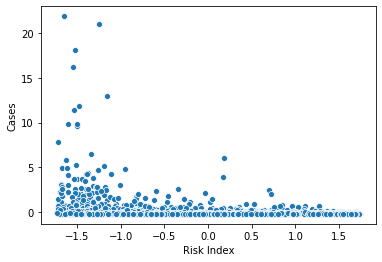

In [196]:
import seaborn as sns

sns.scatterplot(X_stat_stand["Risk Index"], X_stat_stand["Cases"])

# sns.boxplot(y="Cases", x="Poverty", data=X_stat_stand)

In [185]:
import statsmodels.formula.api as smf

fit1 = smf.ols("Cases ~ Poverty", data=X_stat_stand).fit()

fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     6262.
Date:                Wed, 12 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:43:10   Log-Likelihood:                -2735.4
No. Observations:                3142   AIC:                             5475.
Df Residuals:                    3140   BIC:                             5487.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.674e-18      0.010   8.41e-16      1.000      -0.020       0.020
Poverty        0.8161      0.010     79.133      0.000       0.796       0.836
==============================================================================
Omnibus:                     5096.449   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5034360.966
Skew:                          10.341   Prob(JB):                         0.00
Kurtosis:                     198.005   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

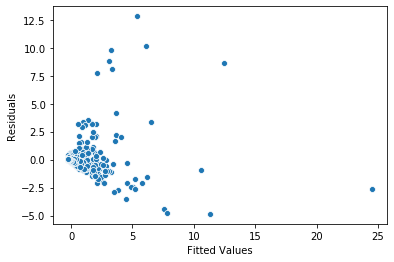

In [186]:
import matplotlib.pyplot as plt

sns.scatterplot(fit1.fittedvalues, fit1.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()